# Random Forest Interpretation 

In [16]:
2020-7-7 14:52:43 

## Imports

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.structured import *

/home/eclipse/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [109]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from pandas_summary import DataFrameSummary
from sklearn import metrics
from IPython.display import display
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# sns.set_style('darkgrid')

## Processing Data

In [4]:
df_raw = pd.read_feather('tmp/df_raw1')

In [5]:
df, y, nas = proc_df(df_raw, 'SalePrice', subset=100000)

In [6]:
df.shape, y.shape

((100000, 66), (100000,))

In [7]:
def split(data_set, size):
    return data_set[:size], data_set[size:]
test_size = 12000
size = len(df) - test_size

X_train, X_valid = split(df, size)
y_train, y_valid =  split(y, size)

In [8]:
X_valid.shape, X_train.shape, y_train.shape

((12000, 66), (88000, 66), (88000,))

## Training a model

In [9]:
def rmse(actuals, predicted):
    '''Returns the root mean square log error between the actual value and predicted value '''
    return np.sqrt(mean_squared_error(actuals, predicted))

def print_score(model):
    '''Prints out a series of score about the model passed 
    
    score
    =====
    The R^2 score of the training or validation set
    
    rmse
    ====
    The root mean square log error between the actual price and the predicted price
    '''
    scores = [rmse(y_train , model.predict(X_train)), rmse(y_valid, model.predict(X_valid)),
              model.score(X_train, y_train), model.score(X_valid, y_valid)
            ]
    print(f'The rmse of the train set : {scores[0]}')
    print(f'The rmse of the validation set : {scores[1]}')
    print(f'The score of the train set : {scores[2]}')
    print(f'The score of the validation set : {scores[3]}')

    # adding the oob_score
    if hasattr(model, 'oob_score_'):
        scores.append(model.oob_score_)
        print(f'The OOB_score : {scores[4]}')

In [10]:
rf = RandomForestRegressor(n_estimators=100, max_features=0.5,
                           min_samples_leaf=3, oob_score=True, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=0.5, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=True,
                      random_state=None, verbose=0, warm_start=False)

In [11]:
print_score(rf)

The rmse of the train set : 0.1299371753518424
The rmse of the validation set : 0.2724863433954619
The score of the train set : 0.9645118342293856
The score of the validation set : 0.8637695583418341
The OOB_score : 0.8915636961547942


# Interpretation

## Confidence based on tree variance

In [13]:
set_rf_samples(50000)

In [16]:
rf = RandomForestRegressor(n_estimators=100, max_features=0.5,
                           min_samples_leaf=3, oob_score=True, n_jobs=-1)
rf.fit(X_train, y_train)
print_score(rf)

The rmse of the train set : 0.12973019011521777
The rmse of the validation set : 0.2728099270094045
The score of the train set : 0.9646248069146875
The score of the validation set : 0.8634458128488742
The OOB_score : 0.8920154775603365


In [26]:
def get_predict(t):
    return t.predict(X_valid)
preds = np.stack(parallel_trees(rf, get_predict))
preds[:,0].mean(), np.std(preds[:,0])

(11.263983664685968, 0.2429199865012071)

In [76]:
x = df_raw.copy()
x['pred'] = preds[:,0].mean(axis=0)
x['preds_std'] = preds[:,0].std(axis=0)

In [71]:
x.Enclosure.value_counts()

OROPS                  173932
EROPS                  139026
EROPS w AC              87820
EROPS AC                   17
NO ROPS                     3
None or Unspecified         2
Name: Enclosure, dtype: int64

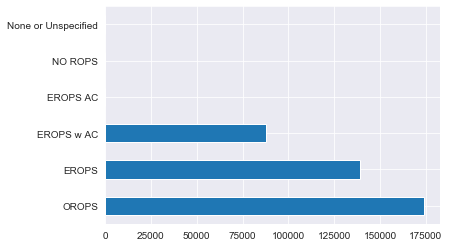

In [74]:
x.Enclosure.value_counts().plot.barh()
plt.show()

In [82]:
fld = ['Enclosure', 'SalePrice', 'pred', 'preds_std']
x[fld].groupby('Enclosure', as_index=False).mean()

,Enclosure,SalePrice,pred,preds_std
0,EROPS,10.067847,11.263984,0.24292
1,EROPS AC,9.964412,11.263984,0.24292
2,EROPS w AC,10.709638,11.263984,0.24292
3,NO ROPS,10.697825,11.263984,0.24292
4,None or Unspecified,9.699503,11.263984,0.24292
5,OROPS,9.825091,11.263984,0.24292


## Feature Importance

In [114]:
fi = rf_feat_importance(rf, df)
fi[:11]

,cols,imp
5,YearMade,0.179967
37,Coupler_System,0.104955
13,ProductSize,0.098979
14,fiProductClassDesc,0.080099
2,ModelID,0.056015
63,saleElapsed,0.052273
10,fiSecondaryDesc,0.045262
39,Hydraulics_Flow,0.043270
19,Enclosure,0.035508
38,Grouser_Tracks,0.035420


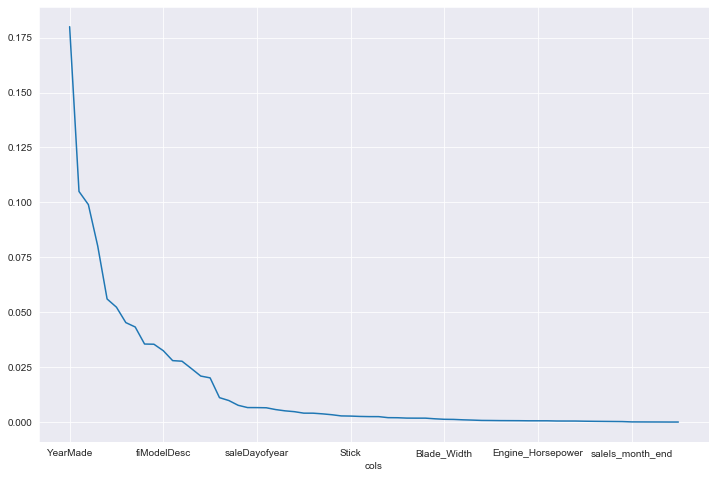

In [115]:
fi.plot('cols', 'imp', figsize=(12, 8), legend=False)
plt.show()

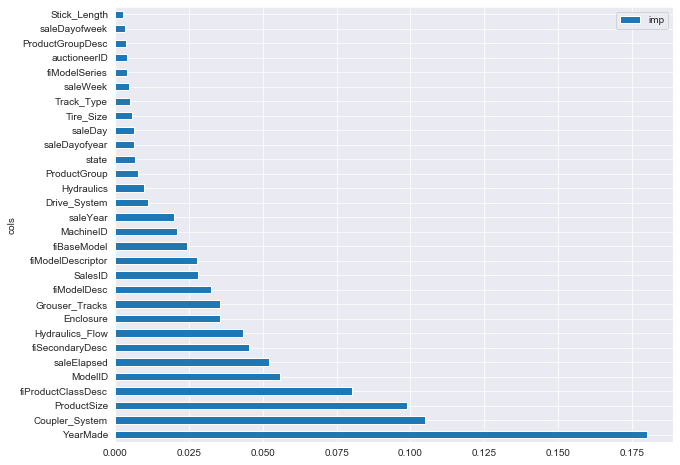

In [113]:
fi[:30].plot.barh('cols', 'imp', figsize=(10, 8))
plt.show()

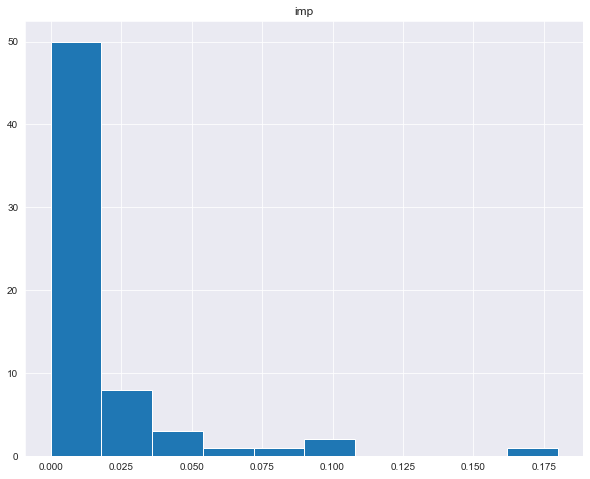

In [157]:
fi.hist(figsize=(10, 8))
plt.show()

In [205]:
to_keep = fi[fi.imp > 0.0005].cols
len(to_keep)

24

In [188]:
df_keep = df[to_keep].copy()
X_train, X_valid = split(df_keep, size)

In [189]:
rf = RandomForestRegressor(n_estimators=100, max_features=0.5,
                           min_samples_leaf=3, oob_score=True, n_jobs=-1).fit(X_train, y_train)
print_score(rf)

The rmse of the train set : 0.13399829198856533
The rmse of the validation set : 0.27432654540776685
The score of the train set : 0.9622588407912669
The score of the validation set : 0.8619233150659187
The OOB_score : 0.8913594388256981


In [193]:
fi = rf_feat_importance(rf, df_keep)
fi[:10]

,cols,imp
0,YearMade,0.178724
2,ProductSize,0.102102
3,fiProductClassDesc,0.081393
1,Coupler_System,0.081032
4,ModelID,0.060110
7,Hydraulics_Flow,0.057085
5,saleElapsed,0.054288
9,Grouser_Tracks,0.049010
6,fiSecondaryDesc,0.048266
10,fiModelDesc,0.036146


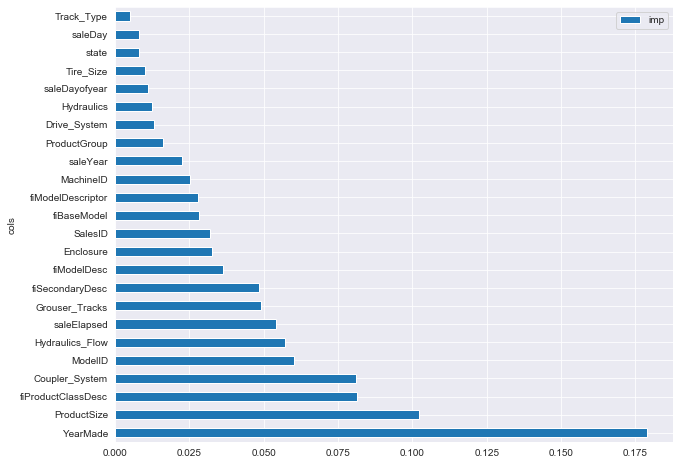

In [206]:
fi.plot.barh('cols', 'imp', figsize=(10,8))
plt.show()